# Building a Deep Neural Network with PyTorch

## Initialization

In [204]:
# Load libraries

# OS
import time

# Data manipulation
import numpy as np
import cv2

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Modeling
import torch
import torch.nn as nn
from torch.optim import SGD, Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

print(torch.__version__)
print(cv2.__version__)
!nvidia-smi # check if GPU is available

2.2.0
4.9.0
zsh:1: command not found: nvidia-smi


## Representing an Image

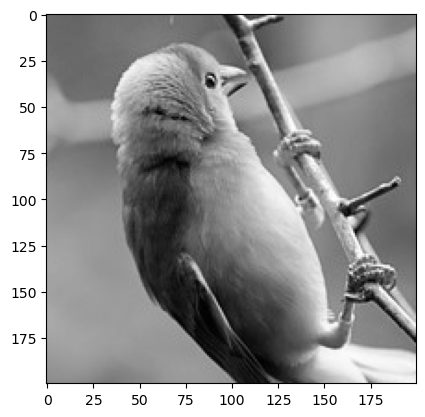

In [145]:
%matplotlib inline

# Load image
img = cv2.imread('sample_image.jpeg')

# Crop image
img = img[70:270,180:380]

# Convert to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display image
plt.imshow(img_gray, cmap='gray')
plt.show()

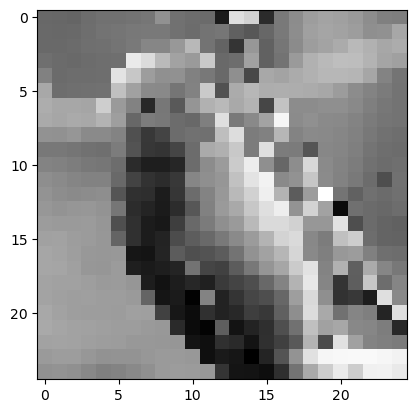

In [146]:
# Convert the image to a 25 x 25 image
img_gray_small = cv2.resize(img_gray, (25, 25))

# Display image
plt.imshow(img_gray_small, cmap='gray')
plt.show()

In [147]:
# Print sample numerical representation
print(img_gray_small[0:5, 0:5])

[[104 103 102 109 113]
 [105 104 105 110 115]
 [106 106 107 111 112]
 [111 107 106 108 110]
 [129 107 109 109 110]]


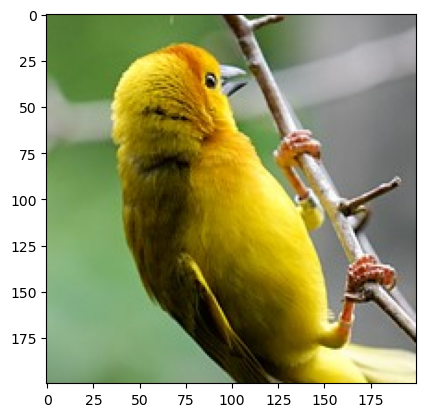

In [148]:
# Convert cropped image to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Print cropped color image
plt.imshow(img_rgb)
plt.show()

## Preparing data for image classification

In [149]:
# Download FMNIST to
data_folder = './data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [150]:
# Store images and labels
imgs = fmnist.data
labels = fmnist.targets

In [151]:
# Inspect tensors dimensions
unique_values = labels.unique()
print(f'images & labels:\n\tX - {imgs.shape}\n\tY - {labels.shape}\n\tY - Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

images & labels:
	X - torch.Size([60000, 28, 28])
	Y - torch.Size([60000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


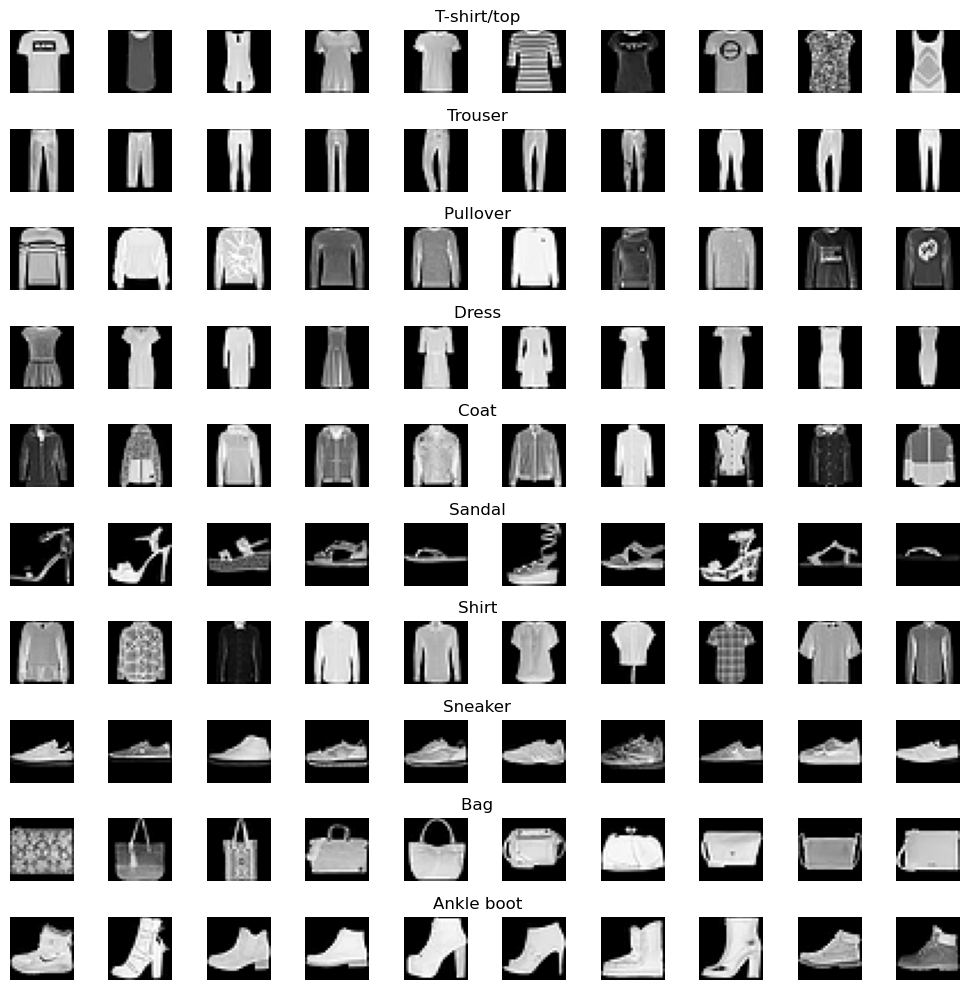

In [152]:
# Plot 10 sample images for each class (total 100 images) print class names on each row
%matplotlib inline
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].grid(False)
        ax[i, j].axis('off')
        ax[i, j].imshow(imgs[labels == i][j], cmap='gray')
        if j == 4:
            ax[i, j].set_title("                " + fmnist.classes[i])
fig.tight_layout()
plt.show()

## Training a Neural Network

In [153]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cpu


In [154]:
# Create Dataset class to fetch images and labels
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.view(-1, 28*28).float()
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].to(device), self.y[idx].to(device)

In [155]:
# Create function to load data
def load_data():
    # Create dataset
    dataset = FMNISTDataset(imgs, labels)

    # Return dataloader
    return DataLoader(dataset, batch_size=32, shuffle=True)

In [156]:
# Create a function to create a simple neural network
def create_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [157]:
# Create a function to train the model on a batch of data
def train_batch(model, loss_fn, optimizer, x, y):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [158]:
# Create a function to calculate the accuracy of the model
@torch.no_grad()
def accuracy(model, x, y):
    model.eval()
    # Get the prediction matrix for a tensor of `x` images
    preds = model(x)
    max_values, argmaxes = preds.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [159]:
# Train the model
model, loss_fn, optimizer = create_model()
train_dl = load_data()
losses, accuracies = [], []
start = time.time()
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    epoch_loss = np.array(epoch_losses).mean()
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1


Epoch 2
Epoch 3
Epoch 4
Epoch 5
Time: 23.86s


/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/2393482277.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


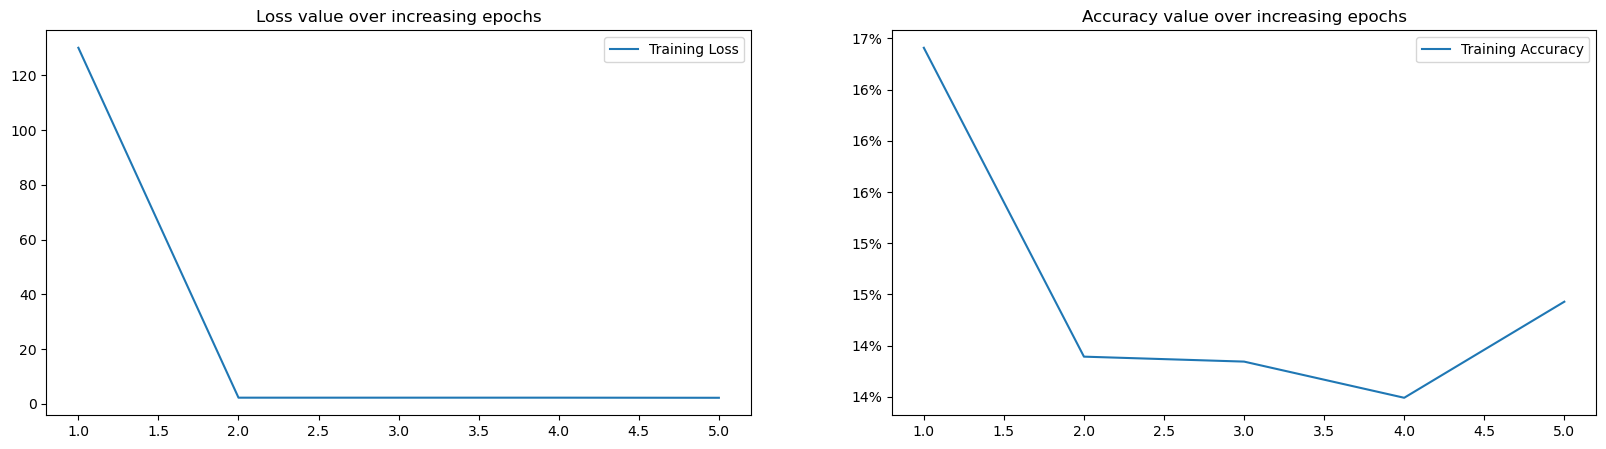

In [160]:
# Plot the loss and accuracy
epochs_list = np.arange(1, epochs+1)
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs_list, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs_list, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.show()

## Improve model accuracy by scaling the dataset

In [161]:
# Modify the Dataset class to scale the images
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.view(-1, 28*28).float() / 255.0
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].to(device), self.y[idx].to(device)

In [162]:
# Train the model
model, loss_fn, optimizer = create_model()
train_dl = load_data()
losses, accuracies = [], []
start = time.time()
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    epoch_loss = np.array(epoch_losses).mean()
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Time: 28.80s


/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/930901403.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


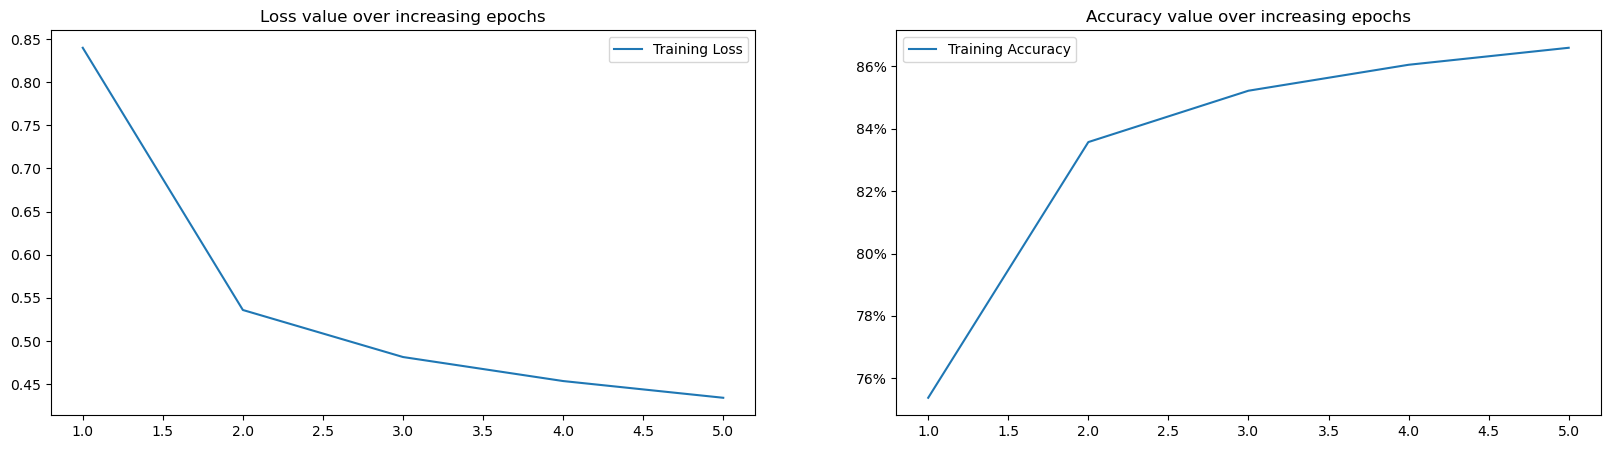

In [163]:
# Plot the loss and accuracy
epochs_list = np.arange(1, epochs+1)
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs_list, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs_list, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()

## Impact of varying Batch Size

In [164]:
# Get the validation set
fmnist_val = datasets.FashionMNIST(data_folder, download=True, train=False)

# Store images and labels
imgs_val = fmnist_val.data
labels_val = fmnist_val.targets

In [165]:
# Modify the model creation function to use Adam optimizer
def create_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [166]:
# Modify the load data function to load the validation set and variable batch size
def load_data(batch_size):
    train_dataset = FMNISTDataset(imgs, labels)
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = FMNISTDataset(imgs_val, labels_val)
    val_dl = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    return train_dl, val_dl

In [167]:
# Create a function to calculate the loss on the validation set at the end of each epoch
@torch.no_grad()
def val_loss(model, x, y):
    model.eval()
    y_pred = model(x)
    val_loss = loss_fn(y_pred, y)
    return val_loss.item()

In [168]:
# Train the model
model, loss_fn, optimizer = create_model()
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1


Epoch 2
Epoch 3
Epoch 4
Epoch 5
Time: 53.53s


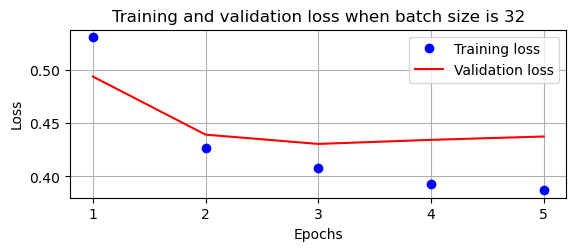

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/2078333118.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


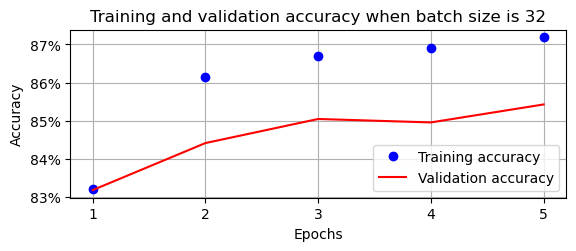

In [169]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss when batch size is {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy when batch size is {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [170]:
# Train the model
model, loss_fn, optimizer = create_model()
batch_size = 10_000
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Time: 7.85s


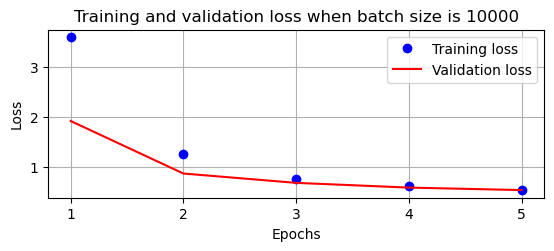

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/2078333118.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


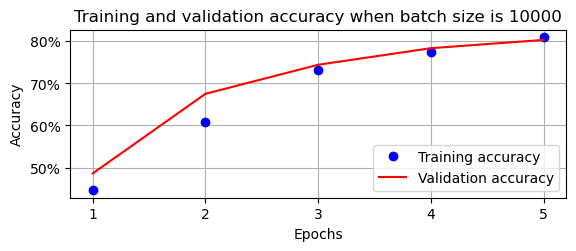

In [171]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss when batch size is {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy when batch size is {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Impact of varying Loss Optimizer

In [172]:
# Modify the model creation function to use SGD optimizer
def create_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [173]:
# Train the model looping through 10 epochs
model, loss_fn, optimizer = create_model()
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Time: 39.29s


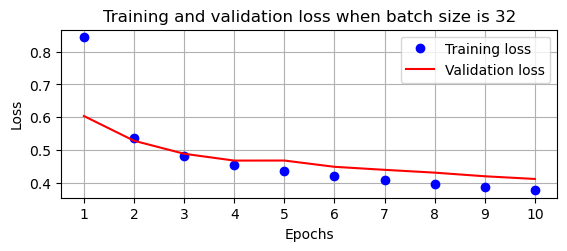

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/2078333118.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


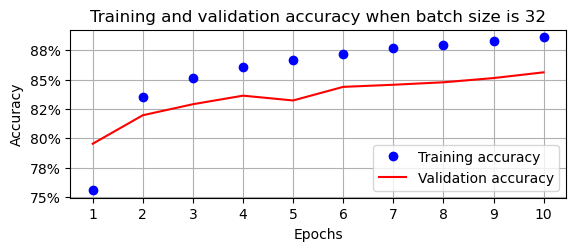

In [174]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss when batch size is {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy when batch size is {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [175]:
# Modify the model creation function to use Adam optimizer
def create_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [176]:
# Train the model looping through 10 epochs using the Adam optimizer
model, loss_fn, optimizer = create_model()
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Time: 84.01s


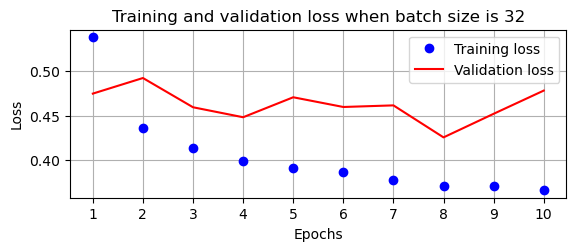

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/2078333118.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


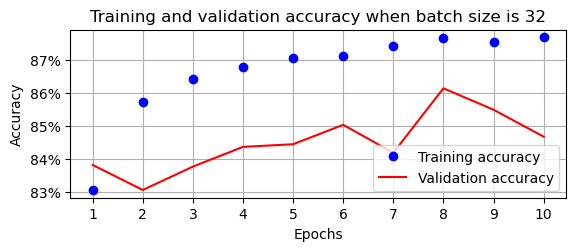

In [177]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss when batch size is {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy when batch size is {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Impact of varying Learning Rate

In [178]:
# Modify the model creation function to use variable learning rate
def create_model(learning_rate):
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

### On a scaled dataset

#### High Learning Rate

In [179]:
# Define a high learning rate
learning_rate = 1e-1

In [180]:
# Train the model looping through 10 epochs using the Adam optimizer
model, loss_fn, optimizer = create_model(learning_rate)
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Time: 74.85s


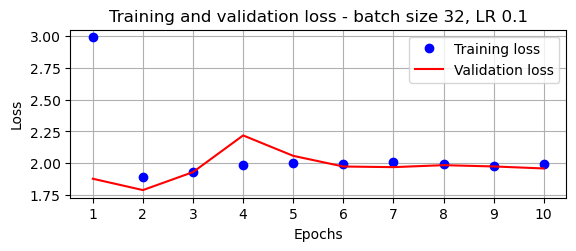

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


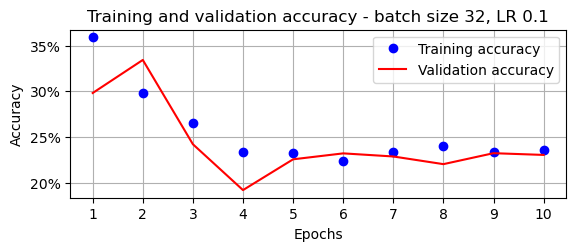

In [181]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

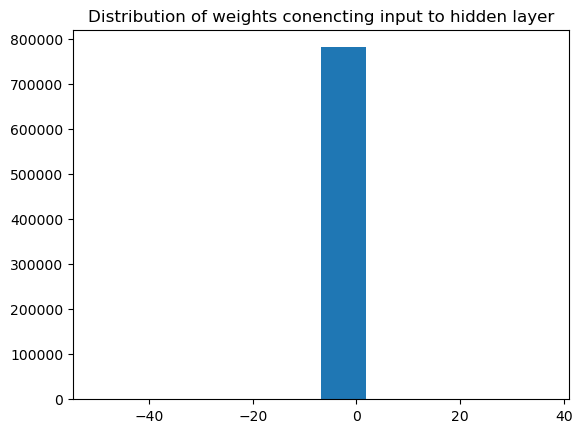

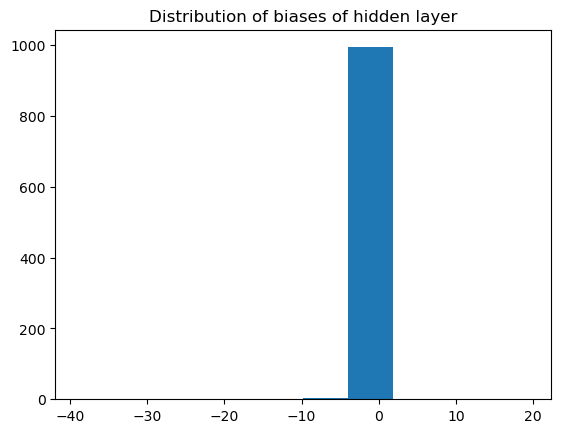

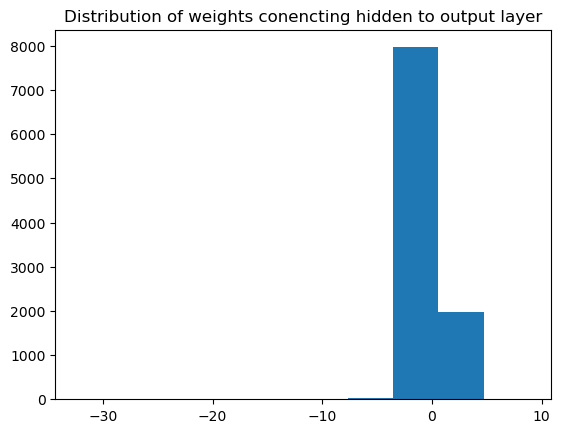

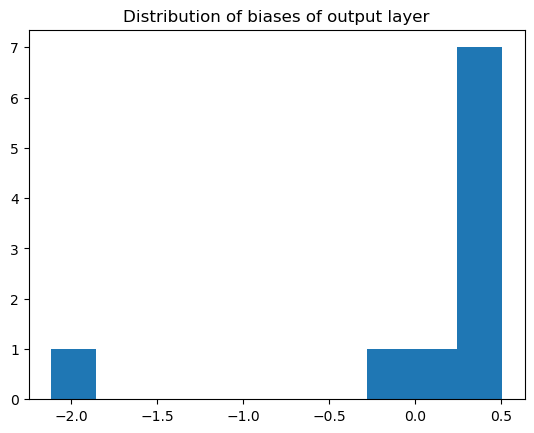

In [182]:
# Plot the distribution of the parameters
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

#### Medium Learning Rate

In [183]:
# Define a medium learning rate
learning_rate = 1e-3

In [184]:
# Train the model looping through 10 epochs using the Adam optimizer
model, loss_fn, optimizer = create_model(learning_rate)
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Time: 85.89s


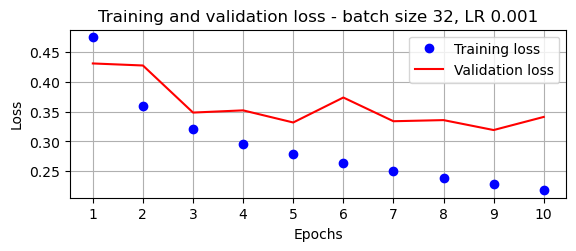

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


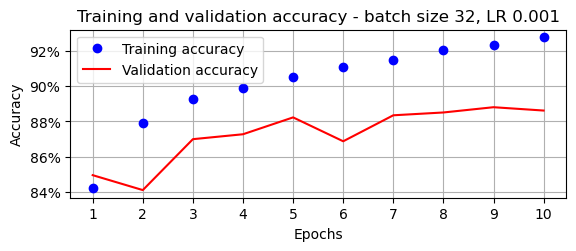

In [185]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

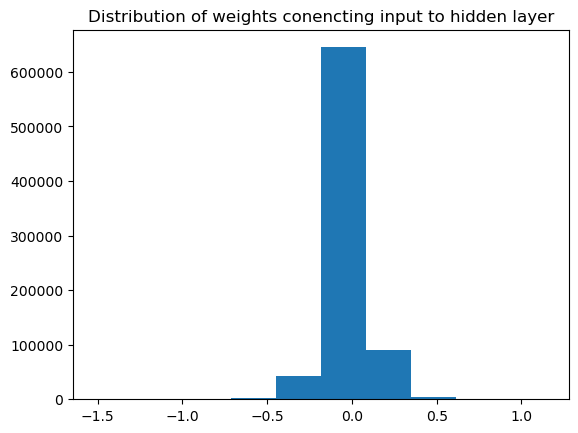

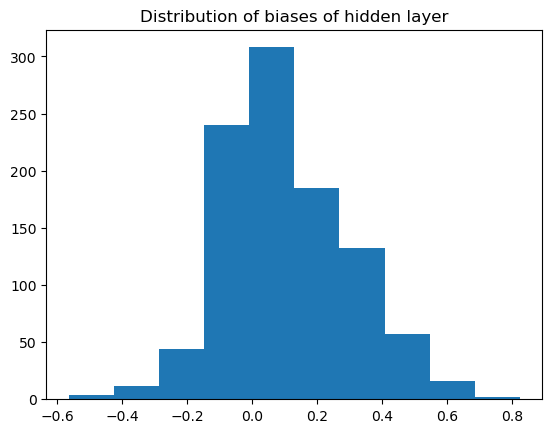

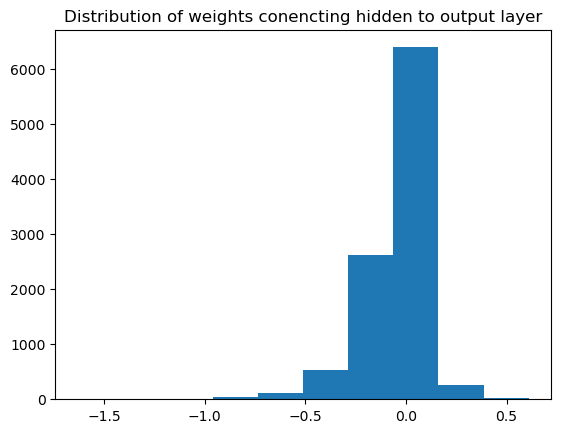

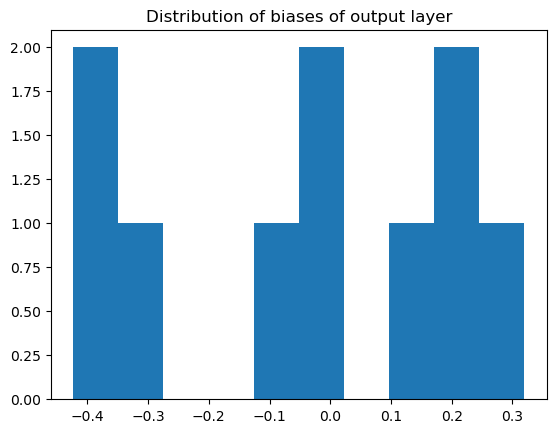

In [186]:
# Plot the distribution of the parameters
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

#### Low Learning Rate

In [187]:
# Define a small learning rate
learning_rate = 1e-5

In [188]:
# Train the model looping through 10 epochs using the Adam optimizer
model, loss_fn, optimizer = create_model(learning_rate)
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 100

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Time: 838.41s


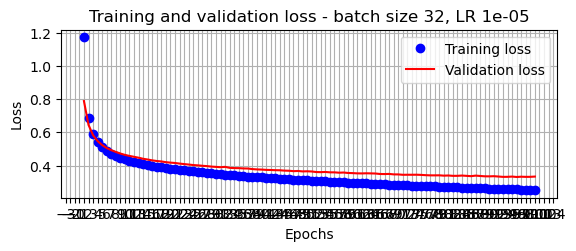

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


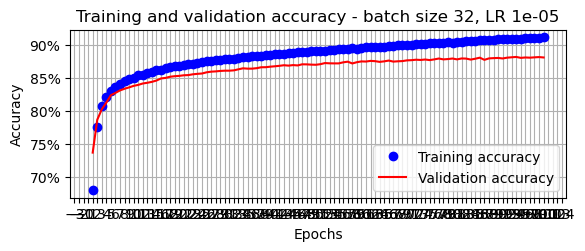

In [189]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

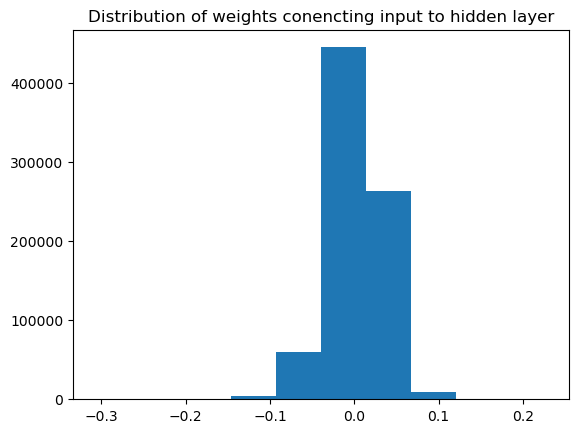

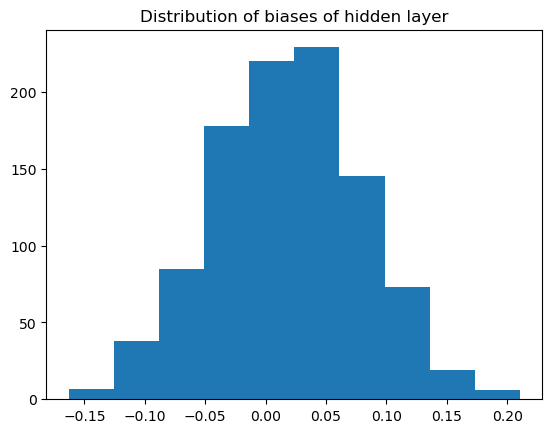

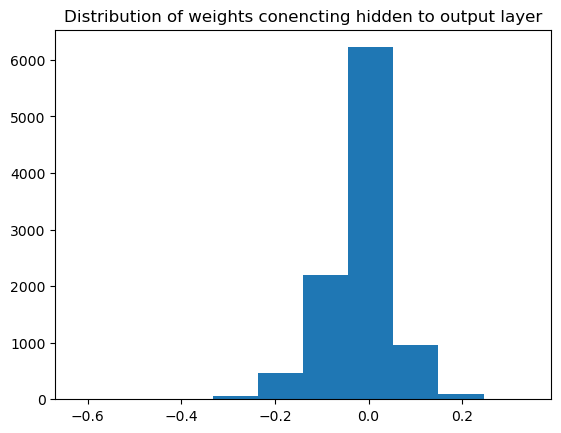

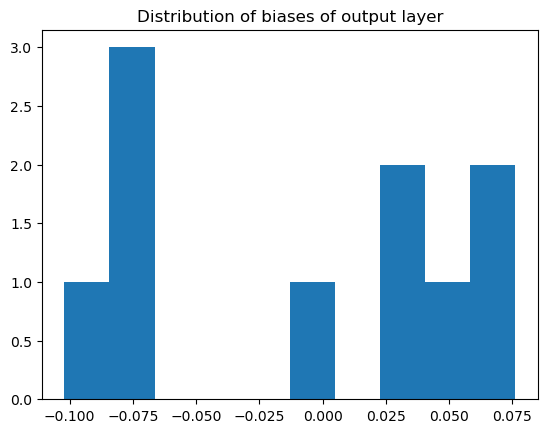

In [190]:
# Plot the distribution of the parameters
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

### On a non-scaled dataset

In [205]:
# Modify the Dataset class so it doesn't scale the images
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.view(-1, 28*28).float()
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].to(device), self.y[idx].to(device)

#### High Learning Rate

In [206]:
# Define a high learning rate
learning_rate = 1e-1

In [207]:
# Train the model looping through 10 epochs using the Adam optimizer
model, loss_fn, optimizer = create_model(learning_rate)
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Time: 87.23s


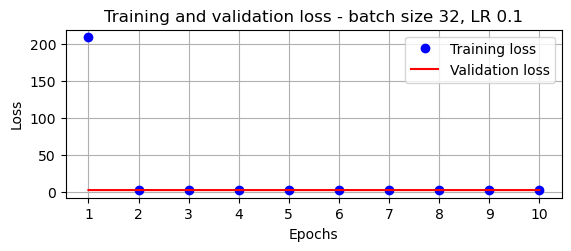

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


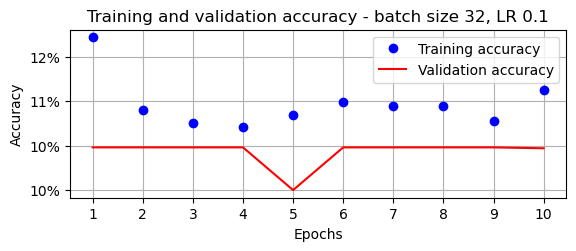

In [208]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

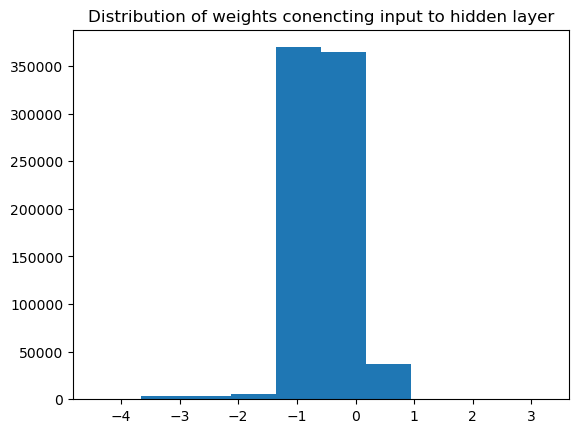

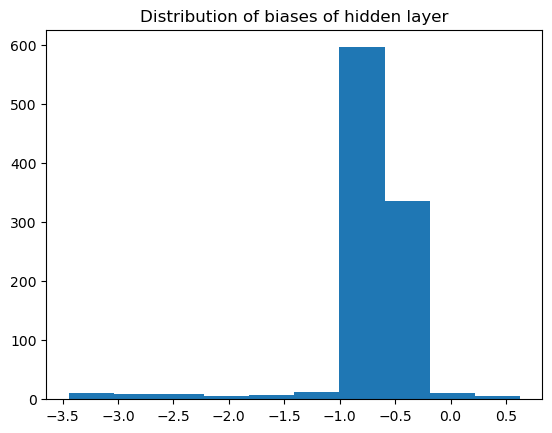

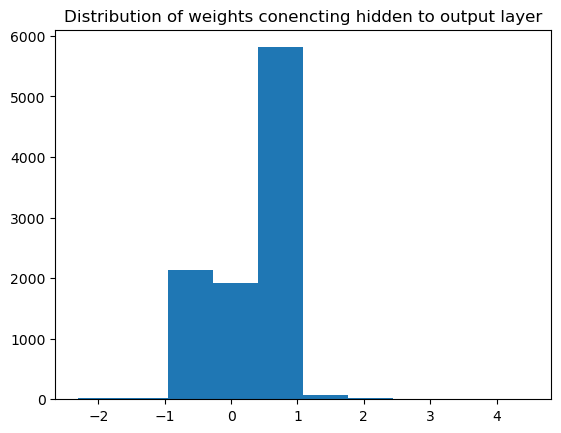

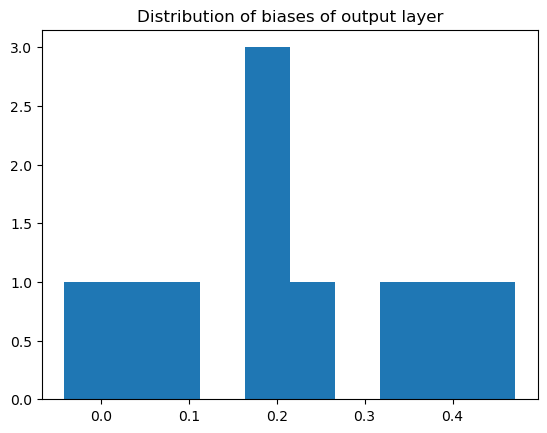

In [209]:
# Plot the distribution of the parameters
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

#### Medium Learning Rate

In [210]:
# Define a medium learning rate
learning_rate = 1e-3

In [211]:
# Train the model looping through 10 epochs using the Adam optimizer
model, loss_fn, optimizer = create_model(learning_rate)
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Time: 102.81s


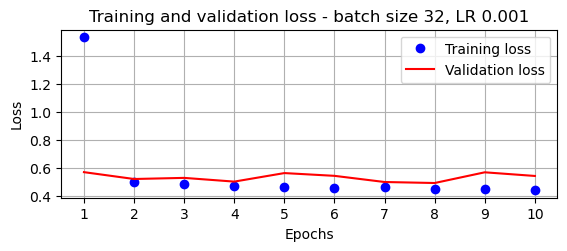

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


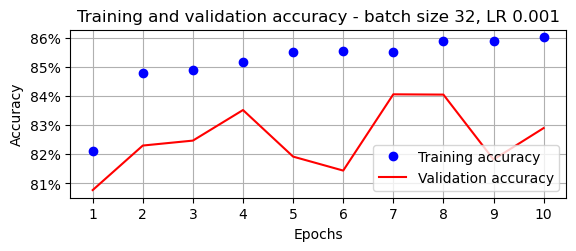

In [212]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

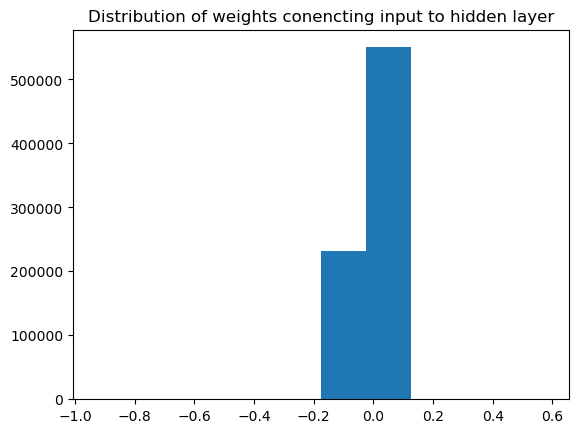

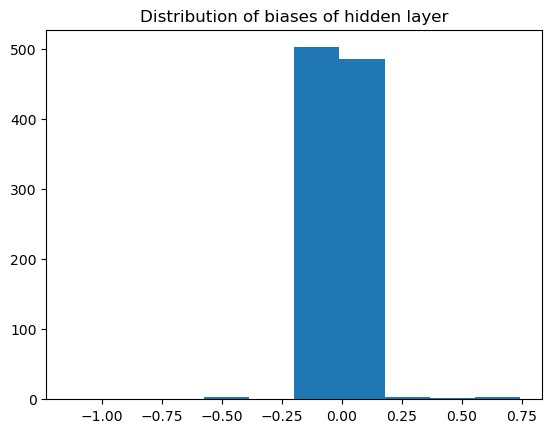

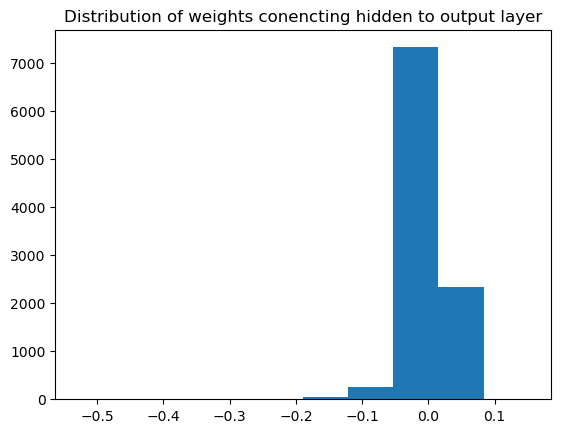

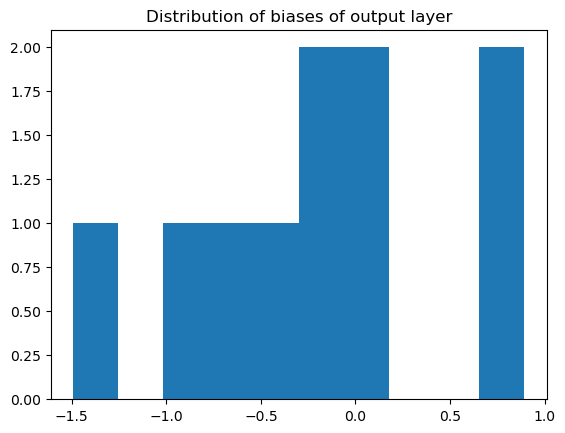

In [213]:
# Plot the distribution of the parameters
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

#### Low Learning Rate

In [214]:
# Define a small learning rate
learning_rate = 1e-5

In [216]:
# Train the model looping through 100 epochs using the Adam optimizer
model, loss_fn, optimizer = create_model(learning_rate)
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 100

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Time: 828.91s


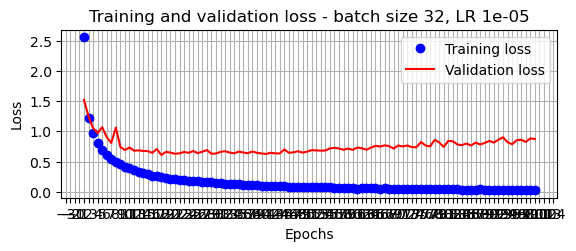

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


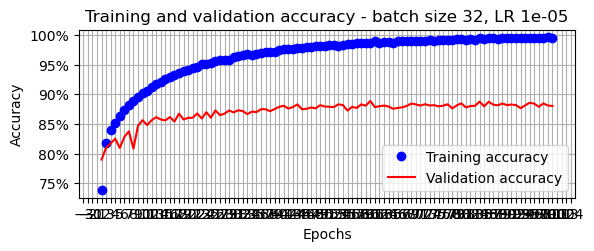

In [217]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

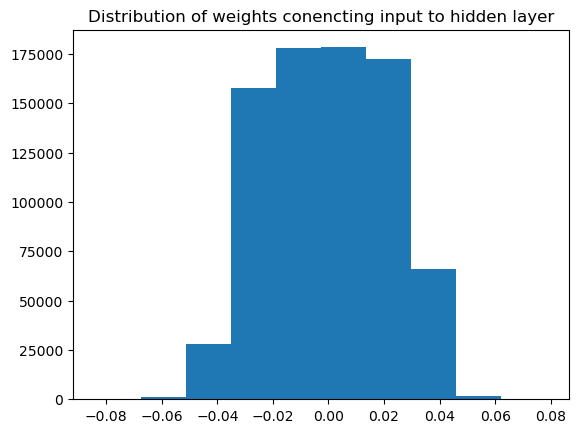

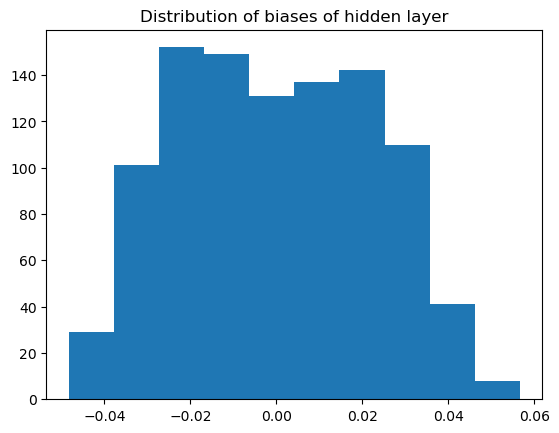

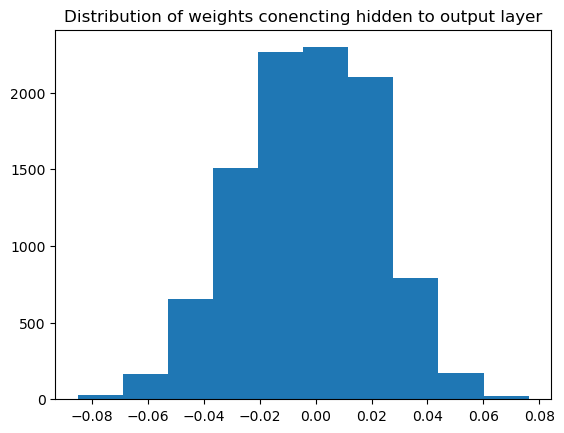

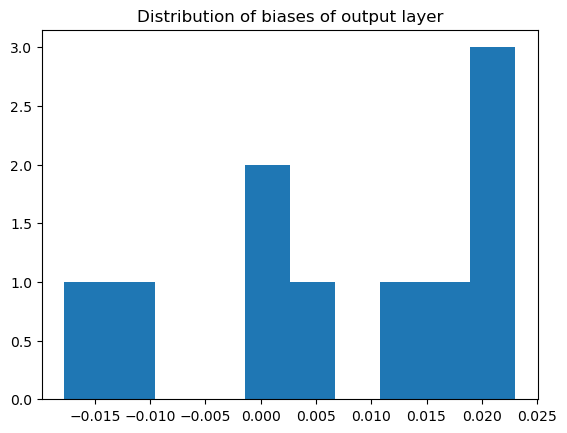

In [218]:
# Plot the distribution of the parameters
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

## Impact of Learning Rate annealing

In [219]:
# Modify the Dataset class to scale the images
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.view(-1, 28*28).float() / 255.0
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].to(device), self.y[idx].to(device)

In [220]:
# Train the model
model, loss_fn, optimizer = create_model(learning_rate=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=0,
    threshold = 0.001,
    verbose=True,
    min_lr = 1e-5,
    threshold_mode = 'abs')
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))
    scheduler.step(val_epoch_loss)

end = time.time()
print(f"Time: {end - start:.2f}s")

/Users/keneth4/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Time: 244.48s


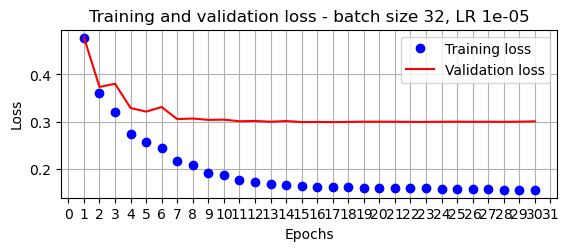

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


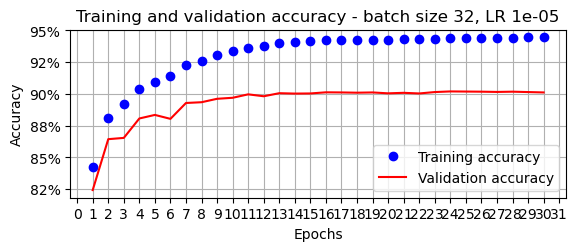

In [221]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Building a deeper Neural Network

In [225]:
# Modify the model creation for the model to have 2 hidden layers
# NOTE: This architecture is not optimal for this problem as it is overfitting
def create_model(learning_rate):
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

In [223]:
# Train the model
model, loss_fn, optimizer = create_model(learning_rate=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=0,
    threshold = 0.001,
    verbose=True,
    min_lr = 1e-5,
    threshold_mode = 'abs')
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))
    scheduler.step(val_epoch_loss)

end = time.time()
print(f"Time: {end - start:.2f}s")

/Users/keneth4/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Time: 496.94s


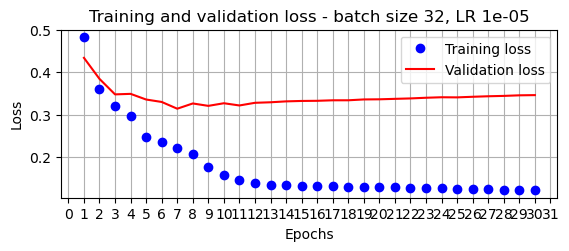

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


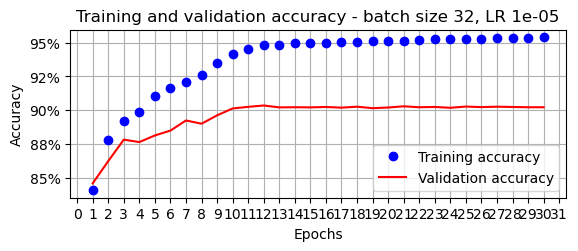

In [224]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Impact of Batch Normalization

In [226]:
# Modify the model creation for the model to have only one hidden layers
def create_model(learning_rate):
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

### Very small inputs without Batch Normalization

In [227]:
# Modify the Dataset class to scale the images to a very small range
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.view(-1, 28*28).float() / (255.0 * 10_000)
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].to(device), self.y[idx].to(device)

In [228]:
# Train the model
model, loss_fn, optimizer = create_model(learning_rate=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=0,
    threshold = 0.001,
    verbose=True,
    min_lr = 1e-5,
    threshold_mode = 'abs')
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))
    scheduler.step(val_epoch_loss)

end = time.time()
print(f"Time: {end - start:.2f}s")

/Users/keneth4/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Time: 268.65s


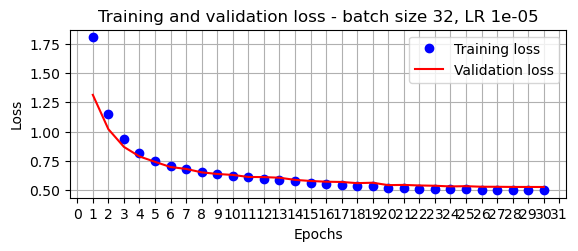

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


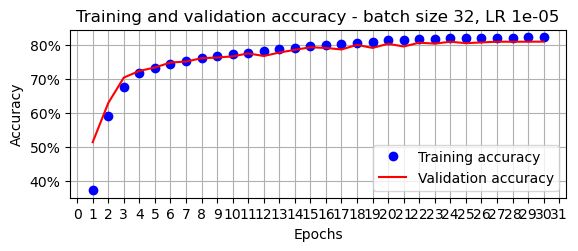

In [229]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

### Very small inputs with Batch Normalization

In [230]:
# Modify the model creation for the model to include batch normalization
def create_model(learning_rate):
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

In [231]:
# Train the model
model, loss_fn, optimizer = create_model(learning_rate=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=0,
    threshold = 0.001,
    verbose=True,
    min_lr = 1e-5,
    threshold_mode = 'abs')
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))
    scheduler.step(val_epoch_loss)

end = time.time()
print(f"Time: {end - start:.2f}s")

/Users/keneth4/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Time: 301.70s


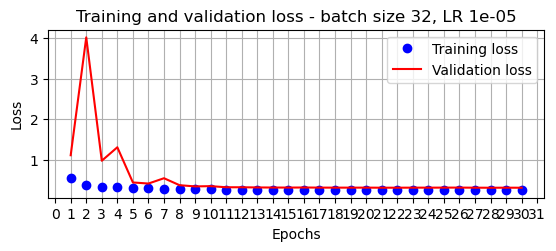

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


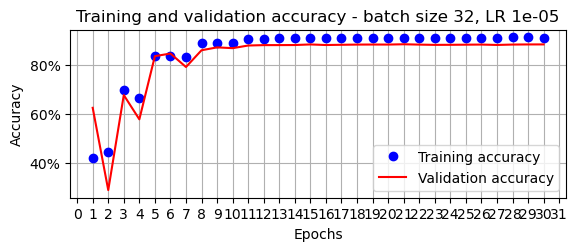

In [232]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Impact of Dropout

In [235]:
# Modify the model creation for the model to include dropout
def create_model(learning_rate):
    model = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(28*28, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

In [236]:
# Train the model
model, loss_fn, optimizer = create_model(learning_rate=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=0,
    threshold = 0.001,
    verbose=True,
    min_lr = 1e-5,
    threshold_mode = 'abs')
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))
    scheduler.step(val_epoch_loss)

end = time.time()
print(f"Time: {end - start:.2f}s")

/Users/keneth4/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Time: 302.10s


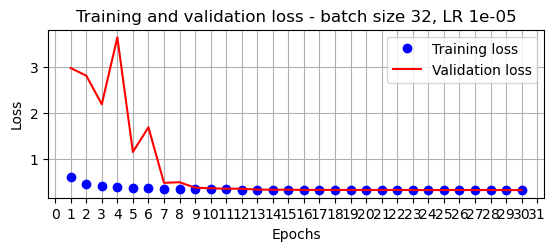

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


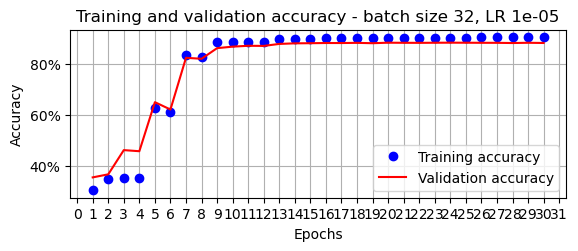

In [237]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Impact of Regularization

### L1 Regularization

In [238]:
# Modify the train batch function to use l1 regularization
def train_batch(model, loss_fn, optimizer, x, y, l1_lambda=0.0001):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    l1_reg = torch.tensor(0.)
    for param in model.parameters():
        l1_reg += torch.norm(param, 1)
    loss = loss_fn(y_pred, y) + l1_lambda * l1_reg
    loss.backward()
    optimizer.step()
    return loss.item()

In [239]:
# Train the model
model, loss_fn, optimizer = create_model(learning_rate=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=0,
    threshold = 0.001,
    verbose=True,
    min_lr = 1e-5,
    threshold_mode = 'abs')
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))
    scheduler.step(val_epoch_loss)

end = time.time()
print(f"Time: {end - start:.2f}s")

/Users/keneth4/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Time: 426.77s


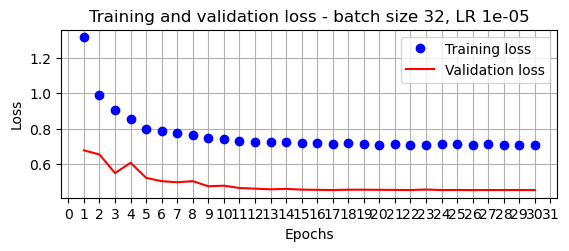

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


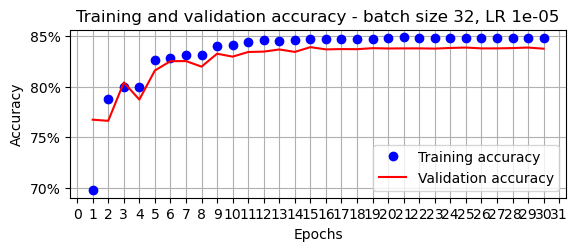

In [240]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

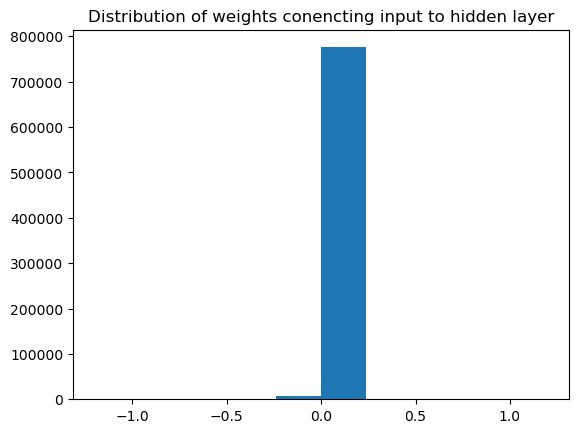

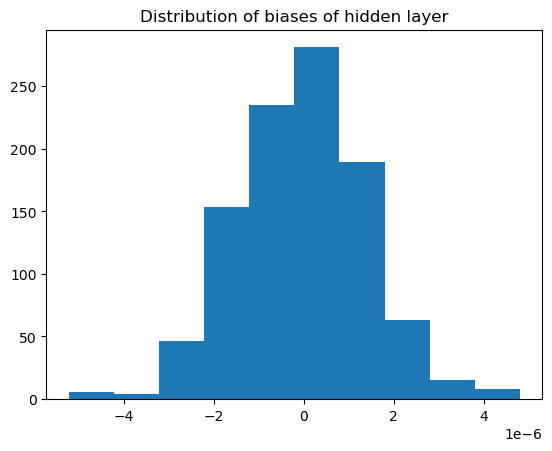

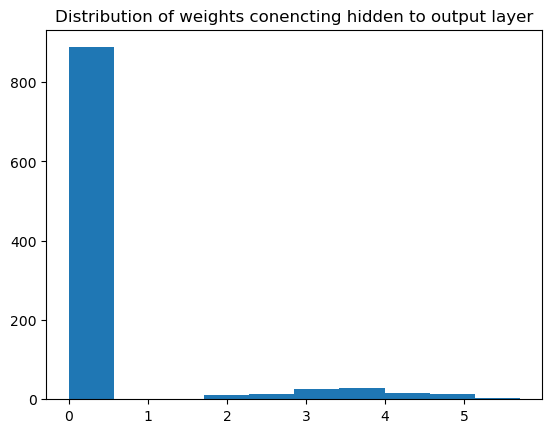

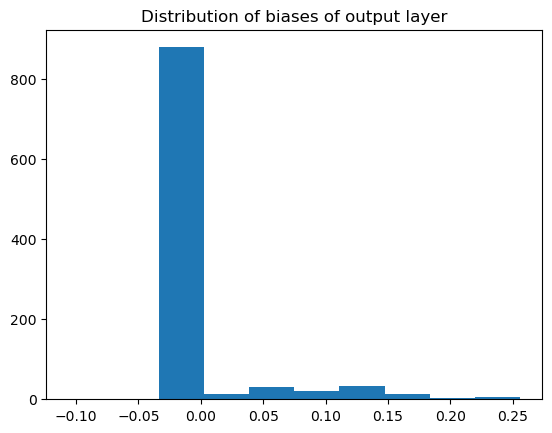

In [242]:
# Plot the distribution of the parameters
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

### L2 Regularization

In [241]:
# Modify the train batch function to use l2 regularization
def train_batch(model, loss_fn, optimizer, x, y, l2_lambda=0.01):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param, 2)
    loss = loss_fn(y_pred, y) + l2_lambda * l2_reg
    loss.backward()
    optimizer.step()
    return loss.item()

In [243]:
# Train the model
model, loss_fn, optimizer = create_model(learning_rate=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=0,
    threshold = 0.001,
    verbose=True,
    min_lr = 1e-5,
    threshold_mode = 'abs')
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))
    scheduler.step(val_epoch_loss)

end = time.time()
print(f"Time: {end - start:.2f}s")

/Users/keneth4/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Time: 396.67s


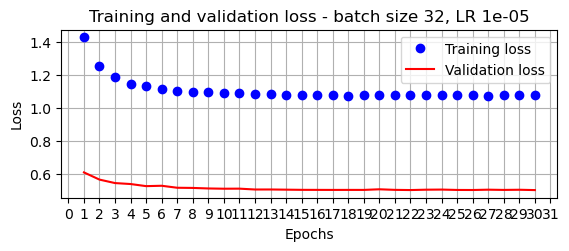

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_81203/788939420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


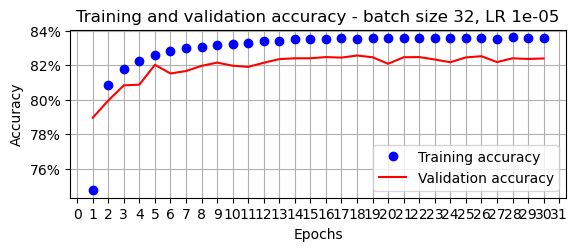

In [244]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy - batch size {batch_size}, LR {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

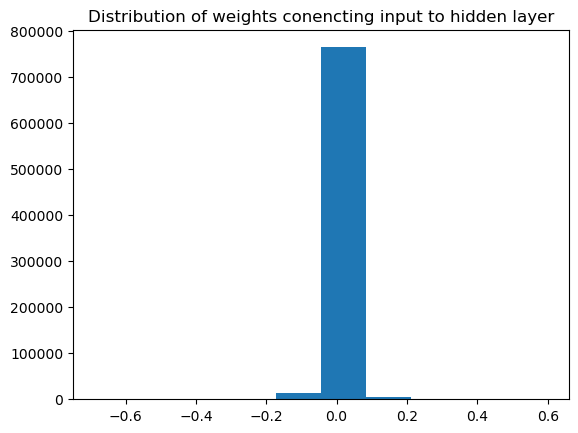

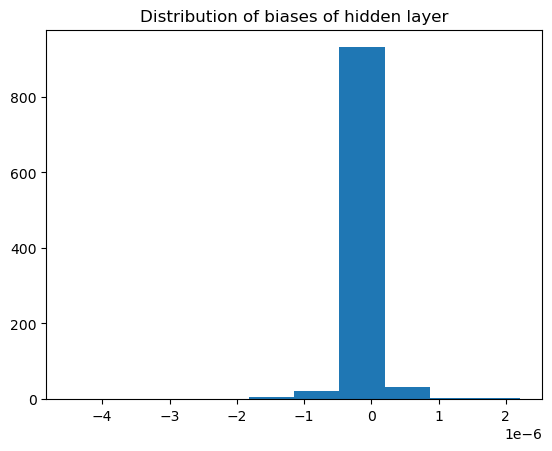

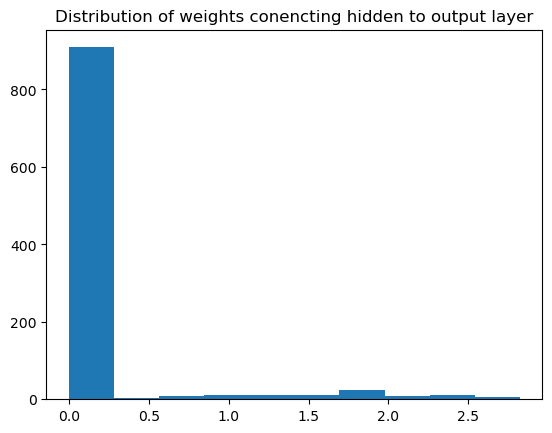

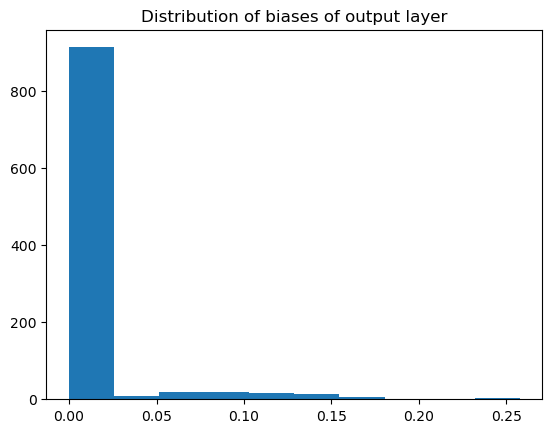

In [245]:
# Plot the distribution of the parameters
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 